In [11]:
action_types = ['default', 'grenade', 'shield', 'reload', 'punch', 'spear', 'hammer', 'portal', 'spider', 'logout']

In [12]:
import tensorflow as tf
import platform

print(f'Python Platform: {platform.platform()}')
print(f'Tensorflow Version: {tf.__version__}')
gpu = len(tf.config.list_physical_devices('GPU'))>0
print('GPU is', 'available' if gpu else 'NOT AVAILABLE')

Python Platform: Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Tensorflow Version: 2.13.0
GPU is NOT AVAILABLE


In [13]:
# Read CSV

import sys
import os
import csv
import numpy as np

home_path = sys.path[0]
rel_path = 'trim_util/trimmed_csv'
total_path = os.path.join(home_path, rel_path)

X = []
y = []

for file in os.listdir(total_path):
    if file.endswith(".csv"):
        p = os.path.join(total_path, file)
        f = open(p, 'r')
        r = csv.reader(f, delimiter=',')
        next(r)
        X.append(list(r))
        y.append(file.split('_')[0])

X = np.array(X)
X = X.astype(float)
y = np.array([action_types.index(s) for s in y])
print(np.info(X))
print(y[0])

class:  ndarray
shape:  (40, 40, 3)
strides:  (960, 24, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x55dd704b8e70
byteorder:  little
byteswap:  False
type: float64
None
2


In [14]:
# Normalize each sample for training

from scipy.stats import zscore
from scipy import signal

noscale_X = X.copy()

# Extract label

for sample in X:
    signal.detrend(sample, axis=0)
    zscore(sample, axis=0)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

X_train.shape, X_test.shape

((32, 40, 3), (8, 40, 3))

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool2D, Input
from tensorflow.keras.optimizers import Adam

num_classes = len(action_types)

model = Sequential()
model.add(Input(shape=(40, 3))) # actually should be (40, 12)
model.add(Conv1D(16, 3, activation='relu'))
model.add(Conv1D(32, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 38, 16)            160       
                                                                 
 conv1d_2 (Conv1D)           (None, 34, 32)            2592      
                                                                 
 flatten_1 (Flatten)         (None, 1088)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                69696     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 73098 (285.54 KB)
Trainable params: 7309

In [17]:
num_epochs = 20
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20


1/1 [==============================] - 1s 525ms/step - loss: 3.8402 - accuracy: 0.0938 - val_loss: 0.0574 - val_accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 24ms/step - loss: 0.9136 - accuracy: 0.6875 - val_loss: 9.1762e-04 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 24ms/step - loss: 0.1425 - accuracy: 0.9375 - val_loss: 5.3925e-05 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 22ms/step - loss: 0.0759 - accuracy: 0.9688 - val_loss: 5.5879e-06 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 23ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 7.3016e-07 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 22ms/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 8.9407e-08 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 23ms/step - loss: 3.1412e-04 - accuracy: 1.0000 - val_loss: 1.4901e-08 - val_accuracy: 1.0000
Epoch 8/2

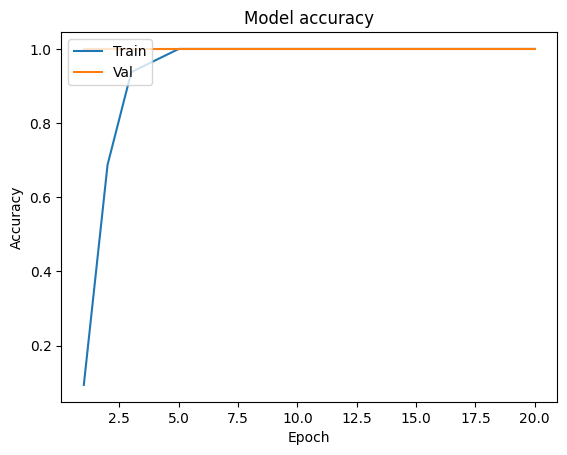

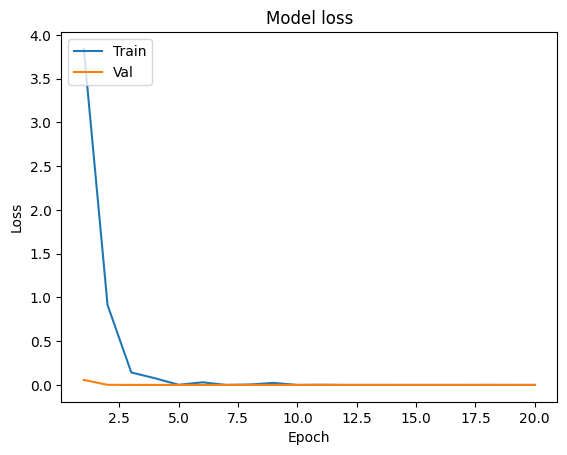

In [21]:
import matplotlib.pyplot as plt

def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, num_epochs)

In [19]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# predict_classes generates class predictions for the input samples.

# y_pred = model.predict(X_test)
# y_classes = np.argmax(y_pred,axis=1)
# 
# print(y_test)
# 
# mat = confusion_matrix(y_test, y_classes)
# plot_confusion_matrix(conf_mat=mat, class_names=action_types, show_normed=True, figsize=(8,8))

In [20]:
# Save model
import os, sys

# The weights are arranged in such a way that: 
#   weights[x] contains data for each column in each filter
#   weights[][y] contains data for each row in each filter
#   weights[][][z] indexes each filter
# So weights[8][4][0] references the 8th column and 4th row of the 0th filter.

# First Conv1D weights
cfd = sys.path[0]
folder_name = 'HLS_CNN'
conv1_w = open(os.path.join(cfd, folder_name, 'conv1_weights.txt'), "w")
tensor = model.layers[0].get_weights()[0]

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        for k in range(len(tensor[0][0])):
            conv1_w.write(str(tensor[i][j][k]))
            if i < len(tensor) - 1 or j < len(tensor[0]) - 1 or k < len(tensor[0][0]) - 1:
                conv1_w.write(',')

conv1_w.close()

# First Conv1D biases
conv1_b = open(os.path.join(cfd, folder_name, 'conv1_biases.txt'), "w")
biases = model.layers[0].get_weights()[1]
conv1_b.write(",".join(str(x) for x in biases))
conv1_b.close()

# Second Conv1D weights
cfd = sys.path[0]
conv2_w = open(os.path.join(cfd, folder_name, 'conv2_weights.txt'), "w")
tensor = model.layers[1].get_weights()[0]

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        for k in range(len(tensor[0][0])):
            conv2_w.write(str(tensor[i][j][k]))
            if i < len(tensor) - 1 or j < len(tensor[0]) - 1 or k < len(tensor[0][0]) - 1:
                conv2_w.write(',')

conv2_w.close()

# Second Conv1D biases
conv2_b = open(os.path.join(cfd, folder_name, 'conv2_biases.txt'), "w")
biases = model.layers[1].get_weights()[1]
conv2_b.write(",".join(str(x) for x in biases))
conv2_b.close()

# First dense layer weights
tensor = model.layers[3].get_weights()[0]

dense1_w = open(os.path.join(cfd, folder_name, 'dense1_weights.txt'), "w")

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        dense1_w.write(str(tensor[i][j]))
        if i < len(tensor) - 1 or j < len(tensor[0]) - 1:
            dense1_w.write(',')

dense1_w.close()

# First dense layer biases
dense1_b = open(os.path.join(cfd, folder_name, 'dense1_biases.txt'), "w")
biases = model.layers[3].get_weights()[1]
dense1_b.write(",".join(str(x) for x in biases))
dense1_b.close()

# Second dense layer weights
tensor = model.layers[5].get_weights()[0]

dense2_w = open(os.path.join(cfd, folder_name, 'dense2_weights.txt'), "w")

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        dense2_w.write(str(tensor[i][j]))
        if i < len(tensor) - 1 or j < len(tensor[0]) - 1:
            dense2_w.write(',')

dense2_w.close()

# Second dense layer biases
dense2_b = open(os.path.join(cfd, folder_name, 'dense2_biases.txt'), "w")
biases = model.layers[5].get_weights()[1]
dense2_b.write(",".join(str(x) for x in biases))
dense2_b.close()

In [25]:
# Test against C++
import subprocess

#test_result = subprocess.run([out_loc, '<', test_loc], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
test_loc = os.path.join(cfd, folder_name, 'test.in')
out_loc = os.path.join(cfd, folder_name, 'a.out')

total_tests = 20
total_correct = 0
total_vs_nn = 0
total_nn_correct = 0

test_list = []
test_answers = []
cpp_answer = []

subprocess.run('make', cwd=os.path.join(cfd, folder_name))

for i in range(total_tests):
    choice = np.random.randint(0, len(X))
    test_list.append(X[choice])
    test_answers.append(y[choice])
    
    Xflat = noscale_X[choice].flatten()
    np.savetxt(test_loc, Xflat)
    test_pipe = subprocess.Popen(['cat', test_loc], stdout=subprocess.PIPE)
    out_pipe = subprocess.Popen([out_loc], stdin=test_pipe.stdout, stdout=subprocess.PIPE)
    output = out_pipe.communicate()[0].decode('ascii')
    cpp_answer.append(int(output))

    if int(output) == y[choice]:
        total_correct += 1

prediction = model.predict(tf.reshape(test_list, [total_tests, 40, 3]))

for i in range(total_tests):
    if cpp_answer[i] == np.argmax(prediction[i]):
        total_vs_nn += 1
    if test_answers[i] == np.argmax(prediction[i]):
        total_nn_correct += 1

print('Total tests:', total_tests)
print('Total equal to pyNN:', total_vs_nn)
print('Total correct:', total_correct)
print('% =pyNN:', total_vs_nn / total_tests)
print('pyNN % correct:', total_nn_correct / total_tests)
print('CPP % correct:', total_correct / total_tests)

g++ -g -Wfatal-errors -Wpedantic -pedantic-errors -Wall -Wextra *.cpp 
1/1 [==============================] - 0s 91ms/step
Total tests: 20
Total equal to pyNN: 20
Total correct: 20
% =pyNN: 1.0
pyNN % correct: 1.0
CPP % correct: 1.0
